In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from joblib import Parallel, delayed, cpu_count
from sklearn.metrics import silhouette_score


In [2]:
#the train is already imputed
data_path = 'data/'
# Load the imputed datasets
df_train = pd.read_csv(data_path+'df_imputed_train.csv')
df_test = pd.read_csv(data_path+'df_imputed_test.csv')

In [3]:
# Convert DELIVERY_START to datetime, then to a numeric timestamp, and finally to float64
df_train['DELIVERY_START'] = pd.to_datetime(df_train['DELIVERY_START']).astype('int64').astype('float64')
df_test['DELIVERY_START'] = pd.to_datetime(df_test['DELIVERY_START']).astype('int64').astype('float64')

In [4]:
#Clipping the values of the columns to be between 0 and 1

scaler = StandardScaler()
df_train = scaler.fit_transform(df_train)
df_test = scaler.fit_transform(df_test)

In [5]:
# Dimension reduction
pca = PCA(n_components=0.95)
df_train_pca = pca.fit_transform(df_train)

Running on 14.0 cores.
Parallel processing completed.


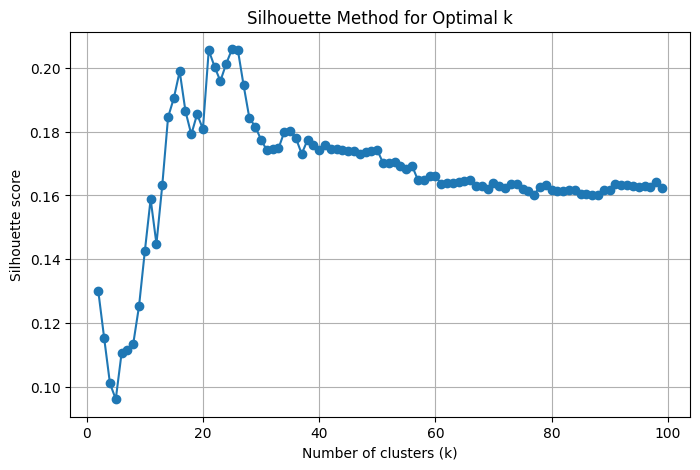

In [6]:
# Choosing the optimal number of clusters using silhouette score
sil_scores = []
k_range = range(2, 100)

def compute_silhouette_score(k):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df_train_pca)
    return silhouette_score(df_train_pca, labels)

# Compute silhouette scores in parallel
try : 
    n_jobs = round(cpu_count() * 0.9, 0)  # Dynamically set the number of jobs to match the available CPUs
    print(f'Running on {n_jobs} cores.') #if your pc can't handle it, you can set n_jobs to 1 or 2
    sil_scores = Parallel(n_jobs=n_jobs)(delayed(compute_silhouette_score)(k) for k in k_range)
    print('Parallel processing completed.')
except : 
    print('Parallel processing failed. Running on a single core. It might take longer. Buy a better pc dumbass.')
    sil_scores = []
    print('Running on 1 core.')
    sil_scores = [compute_silhouette_score(k) for k in k_range]
    print('Single core processing completed.')

max_silhouette_score = max(sil_scores)
optimal_k = k_range[sil_scores.index(max_silhouette_score)]

# Plot the silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(k_range, sil_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette score')
plt.title('Silhouette Method for Optimal k')
plt.grid(True)
plt.show()

Not keeping k=25, because cluster 12 is too small (3)
Not keeping k=24, because cluster 12 is too small (3)
Not keeping k=23, because cluster 12 is too small (3)
Not keeping k=22, because cluster 12 is too small (3)
Not keeping k=21, because cluster 12 is too small (3)
Final selected k: 20
Cluster sizes for k=20:
Cluster 1: 383
Cluster 2: 552
Cluster 3: 1071
Cluster 4: 728
Cluster 5: 692
Cluster 6: 540
Cluster 7: 435
Cluster 8: 455
Cluster 9: 383
Cluster 10: 720
Cluster 11: 583
Cluster 12: 896
Cluster 13: 289
Cluster 14: 270
Cluster 15: 109
Cluster 16: 645
Cluster 17: 455
Cluster 18: 289
Cluster 19: 642
Cluster 20: 450


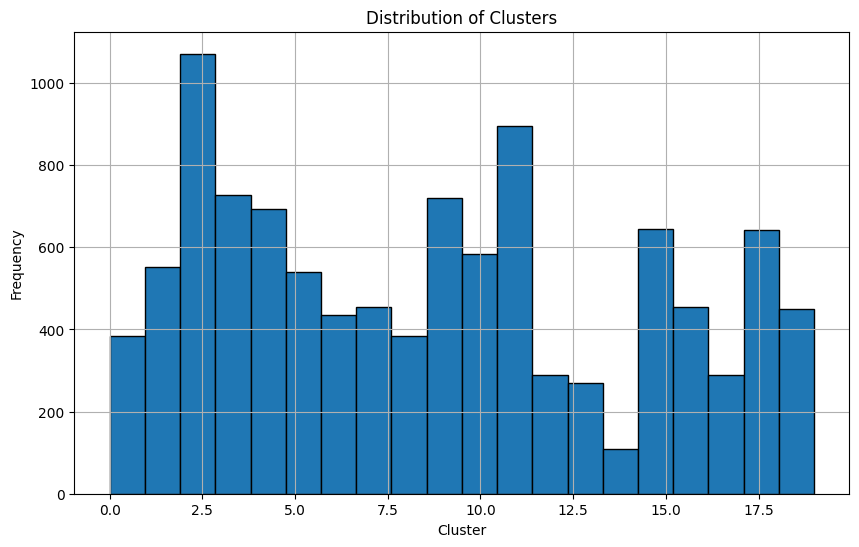

In [13]:
# Apply KMeans clustering

#We want each cluster to represent at least 1% of the dataset, to keep a sort of "representativeness"
threshold_ratio = 0.01
optimal_k_tested = optimal_k

for i in range(optimal_k, 0, -1):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(df_train_pca)

    df_train_cluster = pd.DataFrame(df_train, columns=[f'feature_{x}' for x in range(df_train.shape[1])])
    df_train_cluster['cluster'] = kmeans.labels_

    too_small = False
    for y in range(i):
        cluster_size = len(df_train_cluster[df_train_cluster['cluster'] == y])
        if cluster_size < len(df_train_cluster) * threshold_ratio:
            print(f'Not keeping k={i}, because cluster {y} is too small ({cluster_size})')
            too_small = True
            break  # No need to check other clusters

    if not too_small:
        optimal_k_tested = i
        break  # Found the best k where all clusters are large enough

print(f"Final selected k: {optimal_k_tested}")
print(f"Cluster sizes for k={optimal_k_tested}:")
for y in range(optimal_k_tested):
    cluster_size = len(df_train_cluster[df_train_cluster['cluster'] == y])
    print(f'Cluster {y+1}: {cluster_size}')

# Apply KMeans with the final selected k
df_train = pd.DataFrame(df_train, columns=[f'feature_{x}' for x in range(df_train.shape[1])])
df_train['cluster'] = kmeans.labels_

# graph the clusters distribution
plt.figure(figsize=(10, 6))
plt.hist(df_train['cluster'], bins=optimal_k_tested, edgecolor='black')
plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.title('Distribution of Clusters')
plt.grid(True)
plt.show()

In [9]:
df_train

array([[-1.73729783,  0.11108257,  1.14599369, ..., -0.0756077 ,
        -0.35604932, -0.9915369 ],
       [-1.7369793 , -0.05731312,  1.14599369, ...,  0.02639909,
        -0.07552583, -0.35589248],
       [-1.73666077,  0.01348961,  1.14599369, ..., -0.01920374,
         0.02648164, -0.07537806],
       ...,
       [ 1.71809055, -0.41889   ,  1.14599369, ...,  0.72660535,
         0.72693955,  0.70796413],
       [ 1.71840908, -0.44021283,  1.14599369, ...,  0.54684759,
         0.72669251,  0.72706139],
       [ 1.71872761, -0.39674706,  1.14599369, ...,  0.51596423,
         0.54693357,  0.72681436]])